In [1]:
from __future__ import print_function, absolute_import, division
%matplotlib inline
import tensorflow as tf
import numpy as np
import os
import pandas as pd

import sys
sys.path.insert(0, os.path.join('..', 'pysrc'))

from tfaesthetics.ui import log_progress_ipywidget
from tfaesthetics import dpchallenge

# Test Tensorflow by running the imagenet classification app

In [2]:
import tensorflow.models.image.imagenet.classify_image as classify_image
classify_image.FLAGS._parse_flags()
classify_image.main(None)

/home/brett/anaconda3/envs/tensorflow-gpu/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1811: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)


giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca (score = 0.89233)
indri, indris, Indri indri, Indri brevicaudatus (score = 0.00859)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens (score = 0.00264)
custard apple (score = 0.00141)
earthstar (score = 0.00107)


# Classify images in DPChallenge

## Scrape the images

In [ ]:
dpchallenge.create_databases()
dpchallenge.download_images()
dpchallenge.normalise_rating()

## Run classification on the DPChallenge database

In [ ]:
# get the image files names to process
df = pd.read_hdf(build_database.HDF_FILENAME, key='images')
fnames = list()
for index, row in df.iterrows():
    fname = dpchallenge.Image.filename(index)
    if not os.path.exists(fname):
        continue
    fnames.append(fname)

# set up the results
num_predictions = 5
image_ratings = dict()
image_ratings['image_id'] = list()
for i in range(num_predictions):
    image_ratings['score_id_{}'.format(i + 1)] = list()
    image_ratings['probability_{}'.format(i + 1)] = list()

# load the graph and run it on each image
classify_image.create_graph()
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    
    for fname in log_progress_ipywidget(fnames, every=100):
    
        try:
            image_data = tf.gfile.FastGFile(fname, 'rb').read()
            predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0': image_data})
        except Exception as e:
            print('Predicting {} failed!'.format(fname))
            continue
            
        predictions = np.squeeze(predictions)
        top_k = predictions.argsort()[-num_predictions:][::-1]
        
        image_ratings['image_id'].append(index)
        for i, node_id in enumerate(top_k):
            image_ratings['score_id_{}'.format(i + 1)].append(node_id)
            image_ratings['probability_{}'.format(i + 1)].append(predictions[node_id])

with pd.HDFStore(build_database.HDF_FILENAME) as store:
    store['objects'] = pd.DataFrame(image_ratings, index=image_ratings['image_id'])

### Have a look at the top predicted category

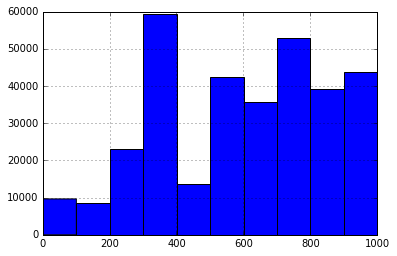

In [3]:
with pd.HDFStore(dpchallenge.HDF_FILENAME) as store:
    df = store['objects']
best_score = df['score_id_1']
best_score.hist()